# Hysteresis simulation

Following the protocol of schwarz and coworkers (schwarz et al., 1998), we mimic cycles of induced hypocalcemia followed by a brief return to normocalcemia and a second hypocalcemic episode. Experimentally, this sequence produced a strong first pth peak (reflecting rapid release from stored hormone), but no second transient peak, as the short recovery at normal calcium was insufficient to replenish storage. Our simulation reproduces this hysteresis effect: an initial sharp rise of pth during the first calcium drop, followed by the absence of a second transient peak upon re-exposure to hypocalcemia.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from ptg_model.model import deriv
from ptg_model.utils import smooth_pw
from ptg_model.parameters import steady_state, steadystate_pat


In [2]:
# --- define base healthy steady state ---
unit_Ca = "mg/dL"
c_opt = 5.0       # healthy midpoint of Ca
p_opt = 3.6       # normal phosphate (mg/dL)
d_opt = 40        # normal calcitriol (ng/L)

y0 = steady_state(c_opt, c_opt, d_opt)
pthopt = y0[3] / 3 * 9.434
s0 = y0[0] + y0[1]




In [3]:
def exp_drop(t, c_high, c_low, tau=10/60):
    A = (c_high - c_low) / (1 - np.exp(-0.5 / tau))
    return c_high - A * (1 - np.exp(-t / tau))

def exp_rise(t, c_start, c_high, tau=3/60):
    return c_start + (c_high - c_start) * (np.exp(t / tau) - 1) / (np.exp((1/6) / tau) - 1)

def make_calcium_endpoints(c_opt=5.0, cycles=2):
    c_high = c_opt
    c_low = 0.85 * c_opt
    x_points = []
    y_points = []
    time = [30/60, 70/60, 10/60]  
    for k in range(cycles):
        base = k * np.sum(time)  

        c_at_0p5 = exp_drop(1, c_high, c_low)

        c_at_2 = exp_rise(1/6, c_at_0p5, c_high)

        if k == 0:
            x_points += [base + 0.0, base + time[0], base + np.sum(time[0:2]), base + np.sum(time)]
            y_points += [c_high, c_at_0p5, c_at_0p5, c_at_2]
        else:
            x_points += [base + time[0], base + np.sum(time[0:2]), base + np.sum(time)]
            y_points += [c_at_0p5, c_at_0p5, c_at_2]

    return np.array([x_points, y_points])


In [4]:
def deriv_with_hysteresis(
    t,
    y,
    endpoints_p,
    endpoints_d,
    c_opt,
    d_opt,
    p_opt,
    c_pat,
    p_pat,
    d_pat,
    s0,
    tf,
    gfr_in,
    y_pat,
    endpoints,
    alpha
):
    c_dynamic = smooth_pw(t, endpoints,alpha)

    return deriv(
        t,
        y,
        endpoints_p,
        endpoints_d,
        c_opt,
        d_opt,
        p_opt,
        c_dynamic,  
        p_pat,
        d_pat,
        s0,
        tf,
        gfr_in,
        y_pat
    )


In [5]:
tf = 200/60 # simulate 240 min

endpoints_p = np.array([[0, 1], [1, 1]])  # phosphate constant
endpoints_d = np.array([[0, 1], [1, 1]])  # vitamin d constant
c_opt = 5.0       
p_opt = 3.6       
d_opt = 40 
c_pat = c_opt
p_pat = p_opt
d_pat = d_opt
pth_pat = 40
gfr_in = 1
y_pat = steadystate_pat(c_pat, p_pat, d_pat, c_opt, p_opt, d_opt, pth_pat, endpoints_d, endpoints_p, gfr_in)
y_pat = np.append(y_pat, [1, 1])
base_args = (
    endpoints_p, endpoints_d,
    c_opt, d_opt, p_opt,
    c_pat, p_pat, d_pat,
    s0, tf, gfr_in, y_pat
)
endpoints = make_calcium_endpoints(c_opt=c_opt, cycles=3)
y_pat = np.array(y0 + [1, 1])  
gfr_in = 1
alpha = 60
args = (endpoints_p, endpoints_d, c_opt, d_opt, p_opt,
        c_pat, p_pat, d_pat, s0, tf, gfr_in, y_pat, endpoints,alpha)



In [6]:
t_span = (0, tf)
sn = solve_ivp(deriv_with_hysteresis, t_span, y_pat,
               args=args, method="BDF", dense_output=True)

print("simulation finished:", sn.success)


simulation finished: True


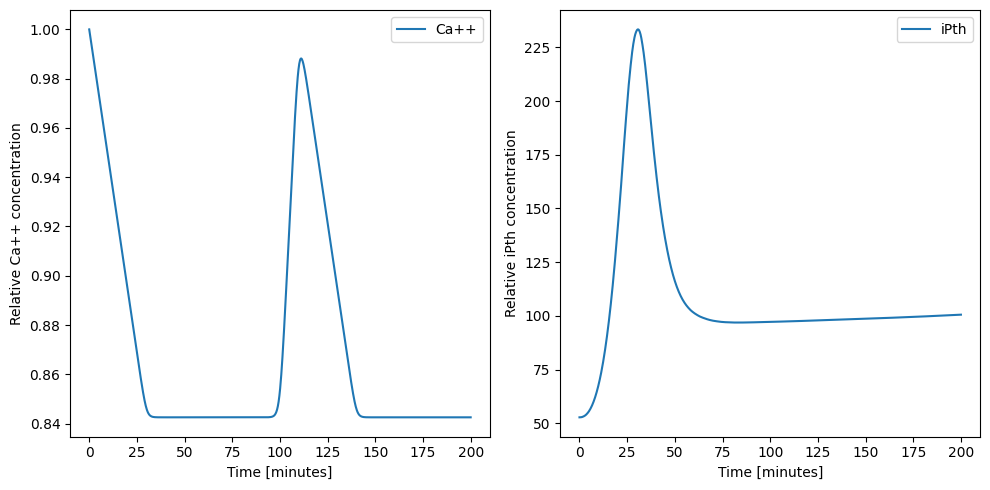

In [7]:
# --- plot results ---
# Calcium and ipth over time
# plot relative to baseline
from ptg_model.utils import smooth_pw_matrix

t_eval = np.linspace(0, tf, 1000)
ca_values = smooth_pw_matrix(t_eval, endpoints,alpha)

ca_percent = ca_values / c_opt
ipth_percent =  sn.sol(t_eval)[3,:]/sn.sol(t_eval)[0,:]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(t_eval*60, ca_percent, label="Ca++")
plt.xlabel("Time [minutes]")
plt.ylabel("Relative Ca++ concentration")
plt.legend()

plt.subplot(1,2,2)
plt.plot(t_eval*60, ipth_percent, label="iPth")
plt.xlabel("Time [minutes]")
plt.ylabel("Relative iPth concentration")
plt.legend()
plt.tight_layout()
plt.show()


# Acute response to Ca++ changes

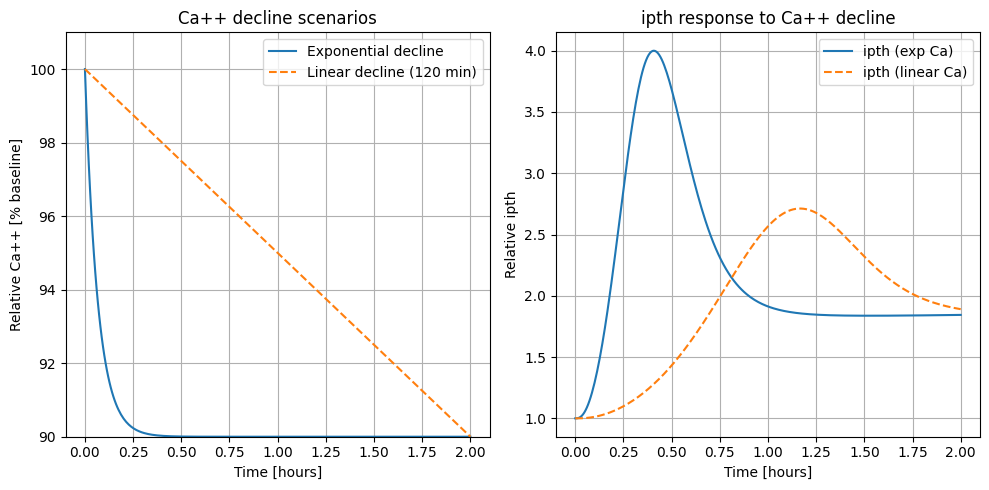

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from ptg_model.model import deriv
from ptg_model.parameters import steady_state, steadystate_pat

# ------------------------
# Calcium profiles
# ------------------------

# Healthy steady state
c_opt = 5     # mg/dL
p_opt = 3.6       # mg/dL
d_opt = 40        # ng/L

def calcium_profile_exp(t, c_opt=c_opt, target_frac=0.90, t_drop=0.2):
    """
    Exponential decline from c_opt to target_frac * c_opt.
    """
    c_high = c_opt
    c_low = target_frac * c_opt
    tau = t_drop / 3.0
    return c_low + (c_high - c_low) * np.exp(-t / tau)

def calcium_profile_linear(t,  c_opt=c_opt, target_frac=0.90, t_drop=2):
    """
    Linear decline from c_opt to target_frac * c_opt in t_drop hours.
    """
    c_high = c_opt
    c_low = target_frac * c_opt
    slope = (c_low - c_high) / t_drop
    return c_high + slope * t if t <= t_drop else c_low

# ------------------------
# simulation setup
# ------------------------

y0 = steady_state(c_opt, c_opt, d_opt)
s0 = y0[0] + y0[1]

# Horizon: 2 hours
tf = 2
t_span = (0, tf)

endpoints_p = np.array([[0, 1], [1, 1]])  # phosphate constant
endpoints_d = np.array([[0, 1], [1, 1]])  # vitamin d constant

c_pat = c_opt
p_pat = p_opt
d_pat = d_opt
gfr_in = 1
pth_pat = 36.9

y_pat = steadystate_pat(c_pat, p_pat, d_pat, c_opt, p_opt, d_opt, pth_pat, endpoints_d, endpoints_p, gfr_in)
y_pat = np.append(y_pat, [1, 1])
base_args = (
    endpoints_p, endpoints_d,
    c_opt, d_opt, p_opt,
    c_pat, p_pat, d_pat,
    s0, tf, gfr_in, y_pat
)

# Collect all base args into one tuple
base_args = (
    endpoints_p, endpoints_d,
    c_opt, d_opt, p_opt,
    c_pat, p_pat, d_pat,
    s0, tf, gfr_in, y_pat
)

# Wrapper: inject dynamic Ca into deriv
def deriv_with_profile(profile_fn, *args):
    def f(t, y):
        (endpoints_p, endpoints_d, c_opt, d_opt, p_opt,
         c_pat, p_pat, d_pat, s0, tf, gfr_in, y_pat) = args
        c_dynamic = profile_fn(t)
        return deriv(t, y,
                     endpoints_p, endpoints_d,
                     c_opt, d_opt, p_opt,
                     c_dynamic,     # replace static c_pat with profile
                     p_pat, d_pat,
                     s0, tf, gfr_in, y_pat)
    return f

# ------------------------
# Run simulations
# ------------------------

sol_exp = solve_ivp(
    deriv_with_profile(calcium_profile_exp, *base_args),
    t_span, y_pat,
    method="BDF", dense_output=True,
    rtol=1e-6, atol=1e-8
)

sol_lin = solve_ivp(
    deriv_with_profile(calcium_profile_linear, *base_args),
    t_span, y_pat,
    method="BDF", dense_output=True,
    rtol=1e-6, atol=1e-8
)

# ------------------------
# plot results
# ------------------------

t_fine = np.linspace(t_span[0], t_span[1], 300)
Ca_exp = np.array([calcium_profile_exp(tt, c_opt) for tt in t_fine])
Ca_lin = np.array([calcium_profile_linear(tt, c_opt) for tt in t_fine])
Ca_exp_percent = 100 * Ca_exp / c_opt
Ca_lin_percent = 100 * Ca_lin / c_opt

y_exp = sol_exp.sol(t_fine)
y_lin = sol_lin.sol(t_fine)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# (1) Calcium profiles
axes[0].plot(t_fine, Ca_exp_percent, label="Exponential decline")
axes[0].plot(t_fine, Ca_lin_percent, "--", label="Linear decline (120 min)")
axes[0].set_ylabel("Relative Ca++ [% baseline]")
axes[0].set_title("Ca++ decline scenarios")
axes[0].set_ylim(90, 101)
axes[0].set_xlabel("Time [hours]")
axes[0].grid(True)
axes[0].legend()

# (2) ipth response (relative to baseline)
axes[1].plot(t_fine, y_exp[3, :] / y_exp[3, 0], label="ipth (exp Ca)")
axes[1].plot(t_fine, y_lin[3, :] / y_lin[3, 0], "--", label="ipth (linear Ca)")
axes[1].set_xlabel("Time [hours]")
axes[1].set_ylabel("Relative ipth")
axes[1].set_title("ipth response to Ca++ decline")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()



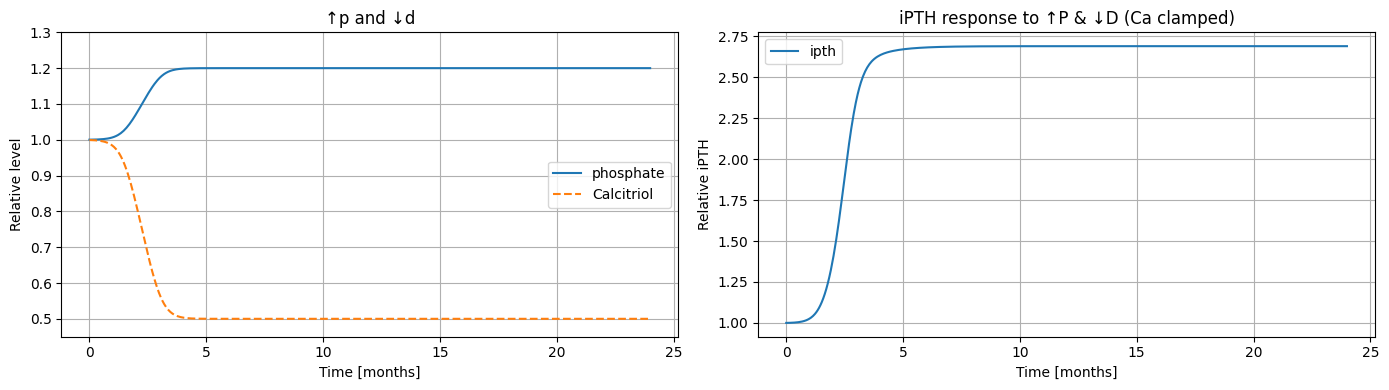

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from ptg_model.model import deriv
from ptg_model.parameters import steady_state, steadystate_pat
from ptg_model.utils import smooth_pw 

# ------------------------
# Baseline (healthy steady state)
# ------------------------
c_opt = 5.0     # mg/dL
p_opt = 3.6     # mg/dL
d_opt = 40.0    # ng/L
pth_pat = 31.7   # pg/mL

y0 = steady_state(c_opt, c_opt, d_opt)
s0 = y0[0] + y0[1]


def make_step_endpoints(multiplier, t_step, tm):
    return np.array([
        [0.0, t_step/2, t_step, tm],      
        [1.0, 1.0, multiplier, multiplier]  
    ])

tm = 24*30*24 # 2 years
t_span = (0, tm)

# Configure the acute changes (adjust as you like)
p_mult = 1.2   # +25% phosphate
d_mult = 0.5   # -25% calcitriol

t_step = 24*30*3 
endpoints_p = make_step_endpoints(p_mult, t_step/tm, 1)
endpoints_d = make_step_endpoints(d_mult, t_step/tm, 1)

gfr_in = 1.0

# Patient baselines
c_pat = c_opt
p_pat = p_opt
d_pat = d_opt
y_pat = steadystate_pat(c_pat, p_pat, d_pat, c_opt, p_opt, d_opt, pth_pat, endpoints_d, endpoints_p, gfr_in)
y_pat = np.append(y_pat, [1, 1])
base_args = (
    endpoints_p, endpoints_d,
    c_opt, d_opt, p_opt,
    c_pat, p_pat, d_pat,
    s0, tm, gfr_in, y_pat
)

def deriv_with_const_C(*args):
    def f(t, y):
        (endpoints_p, endpoints_d, c_opt, d_opt, p_opt,
         c_pat, p_pat, d_pat, s0, tm, gfr_in, y_pat) = args
        return deriv(t, y,
                     endpoints_p, endpoints_d,
                     c_opt, d_opt, p_opt,
                     c_pat,   
                     p_pat, d_pat,
                     s0, tm, gfr_in, y_pat)
    return f


sol = solve_ivp(
    deriv_with_const_C(*base_args),
    t_span, y_pat,
    method="BDF",
    rtol=1e-6, atol=1e-6
)


t_sol = sol.t
y3 = sol.y[3, :]

t_plot = t_sol/tm

p_scale = np.array([smooth_pw(ti, endpoints_p) for ti in t_plot])
d_scale = np.array([smooth_pw(ti, endpoints_d) for ti in t_plot])

# For visualization: p and d profiles (same smooth_pw and tm as in deriv)
p_profile = p_pat * p_scale
d_profile = d_pat * d_scale
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)


# (1) p and d step changes (relative to baseline)
axes[0].plot(t_sol/24/30, p_scale, label="phosphate")
axes[0].plot(t_sol/24/30, d_scale, "--", label="Calcitriol")
axes[0].set_xlabel("Time [months]")
axes[0].set_ylabel("Relative level")
axes[0].set_title("↑p and ↓d")
axes[0].set_ylim(0.45, 1.3)
axes[0].grid(True)
axes[0].legend()

# (2) ipth response (y[3] is secreted pth)
axes[1].plot(t_sol/24/30, y3 / y3[0], label="ipth")
axes[1].set_xlabel("Time [months]")
axes[1].set_ylabel("Relative iPTH")
axes[1].set_title("iPTH response to ↑P & ↓D (Ca clamped)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()
